# Learning debiased embeddings

## 1. Libraries

In [91]:
import os
from pathlib import Path
import numpy as np
import pickle
from tqdm import tqdm
import pandas as pd
import json
import seaborn as sns
import matplotlib.pyplot as plt

from debiaswe.data import load_professions, load_embeddings, load_embeddings_pandas

%matplotlib inline

Matplotlib params.

In [351]:
# General setup
male_bbox = dict(boxstyle ="round", fc ="0.8", color='m')
male_arrowprops = dict(arrowstyle = "->",
                  color='m',
                  linewidth=1)

female_bbox = dict(boxstyle ="round", fc ="0.8", color='b')
female_arrowprops = dict(arrowstyle = "->",
                  color='b',
                  linewidth=1)

neutral_bbox = dict(boxstyle ="round", fc ="0.8", color='g')
neutral_arrowprops = dict(arrowstyle = "->",
                  color='g',
                  linewidth=1)
offset = 45

## 2. Data preparation

Loading the profession file: for each job it is associated a *definitional* and a *stereotypical* score.

In [16]:
professions = load_professions()
print(f'Number of professions found in the file: {len(professions)}')

Loaded professions
Format:
word,
definitional female -1.0 -> definitional male 1.0
stereotypical female -1.0 -> stereotypical male 1.0
Number of professions found in the file: 320


Then we extract the male, female and neutral words by checking for each profession if its sterotypical score $d_w$ is greater or smaller than a predefined threshold $\rho$ (here $\rho = 0.3$).

In [3]:
def get_sets():
    male_words = []
    female_words = []
    neutral_words = []
    threshold = 0.3

    male_words = []
    female_words = []
    neutral_words = []

    for job in professions:
        st = float(job[2])
        if float(st) > threshold:
            male_words.append(job[0])
        elif -float(st) > threshold:
            female_words.append(job[0])
        else:
            neutral_words.append(job[0])

    return male_words, female_words, neutral_words

male_words, female_words, neutral_words = get_sets()
jobs = np.array(professions)[:, 0]

### 2.1 Debiased embeddings
To load the embeddings produced by the debiasing model we simply call the method from the `data` module which will return us a `pandas.DataFrame`.

In [4]:
# vocab, embeddings, word_to_idx, idx_to_word = load_embeddings()
emb_df = load_embeddings_pandas()

We can see that the embeddings loaded are $w \in \mathbb{R}^{300}$.

In [5]:
emb_df.head()

,word,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,300
0,the,0.214484,-0.936429,-0.482297,0.178016,-0.012346,-0.128123,0.154942,-0.051772,-0.072807,...,-0.026935,0.341347,-0.001474,-0.135471,-0.066768,-0.471664,-0.021390,-0.026099,0.454119,1.372781
1,of,0.691771,-0.563567,-0.642893,0.293528,-0.381607,-0.262290,0.329361,0.077962,-0.201108,...,0.304275,-0.035230,0.027677,0.144458,-0.094593,-0.481935,-0.123538,0.391904,0.736023,1.185873
2,and,0.017036,-0.317027,-0.359625,0.493605,-0.538638,-0.264845,0.310016,0.256150,-0.178865,...,-0.247396,-0.051276,0.057986,-0.028516,0.251905,-0.291805,-0.241702,0.251950,0.530691,0.806886
3,in,0.118735,-0.700932,-0.210569,0.546696,-0.987682,-0.106259,-0.114322,0.220718,0.111958,...,0.152707,0.053790,0.068665,-0.027525,0.033012,-0.064333,0.204823,0.259245,0.423288,0.927642
4,a,0.310709,-0.394232,-0.380080,0.161297,-0.253897,-0.083834,-0.347447,0.049588,0.276277,...,0.273594,0.013120,0.225561,0.286412,-0.337665,-0.405250,-0.197888,-0.029707,0.340794,1.284348


Now we can extract the *male*, *female* and *neutral* embeddings from the whole list by simply exploiting the functionalities of pandas.

In [42]:
debug_idx = 14

male_vectors = emb_df.loc[emb_df['word'].isin(male_words)]
print(f'Number of male words: {male_vectors.shape[0]}')

female_vectors = emb_df.loc[emb_df['word'].isin(female_words)]
print(f'Number of female words: {female_vectors.shape[0]}')

neutral_vectors = emb_df.loc[emb_df['word'].isin(neutral_words)]
print(f'Number of neutral words: {neutral_vectors.shape[0]}')

print(100*'=')

print(f'[DEBUG] Male sterotyped profession: {male_vectors.iloc[debug_idx, 0]}')
print(f'[DEBUG] Female sterotyped profession: {female_vectors.iloc[debug_idx, 0]}')
print(f'[DEBUG] Neutral sterotyped profession: {neutral_vectors.iloc[debug_idx, 0]}')

print(100*'=')

Number of male words: 142
Number of female words: 21
Number of neutral words: 128
[DEBUG] Male sterotyped profession: doctor
[DEBUG] Female sterotyped profession: environmentalist
[DEBUG] Neutral sterotyped profession: musician


## 3. Attribute visualization

We take the first 20 gender-specific words and their respective embeddings. Note that in GN-GloVe an embedding $w$ is made by $[w_a, w_g]$ where usually $w_g \in \mathbb{R}^1$ (i.e., the last column).

We also sort their embedding by descending gender contribute, indicating by the facto the terms that most are contribuiting to the gender bias. 

In [80]:
n = 20
male_vectors_g = male_vectors[male_vectors.columns[-1]].sort_values(ascending=False)
# male_vectors_g = male_vectors_g.sort_values(ascending=False).reset_index().drop("index", axis=1)[300]
male_vectors_g = male_vectors_g[:n].to_numpy()

female_vectors_g = female_vectors[female_vectors.columns[-1]].sort_values(ascending=False)
# female_vectors_g = female_vectors_g.sort_values().reset_index().drop("index", axis=1)[300]
female_vectors_g  = female_vectors_g[:n].to_numpy()

Similarly for the neutral words, we only take a greater set with respect to the gender specific ones.

In [201]:
# neutral_vectors_g = np.concatenate((male_vectors_g[n:], female_vectors_g[n:]))
neutral_vectors_g = neutral_vectors[neutral_vectors.columns[-1]]
# np.random.shuffle(neutral_vectors_g)
neutral_vectors_g  = neutral_vectors_g.to_numpy()

We then random uniformly spread the values along the y-axis in order to visualize them.

In [202]:
y_male = np.random.uniform(0, 250, size=len(male_vectors_g))
y_female = np.random.uniform(0, 250, size=len(female_vectors_g))
y_neutral = np.random.uniform(0, 250, size=len(neutral_vectors_g))

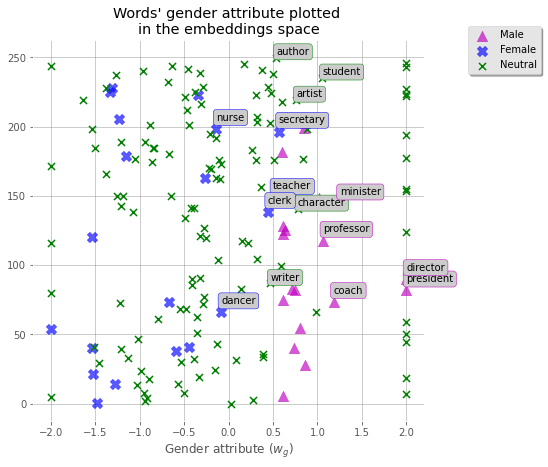

<Figure size 720x720 with 0 Axes>

In [353]:
fig = plt.figure(figsize=(7,7))
ax = plt.subplot(111)
ax.scatter(male_vectors_g, y_male, marker="^", c='m', alpha=0.65, s=110)
ax.scatter(female_vectors_g, y_female, marker="X", c='b', alpha=0.65, s=110)
ax.scatter(neutral_vectors_g, y_neutral, marker="x",  c='g', s=50)
ax.set_facecolor('white')
ax.grid(True, color='gray', alpha=0.5)
ax.set_xlabel("Gender attribute ($w_g$)")
ax.set_title('Words\' gender attribute plotted \nin the embeddings space')

n = 5
for i, m, f, n in zip(range(n), male_vectors['word'], female_vectors['word'], neutral_vectors['word']):
  # print(male_word, female_word, neutral_word)
  plt.annotate(m, (male_vectors_g[i], y_male[i] + 6), bbox = male_bbox)
  plt.annotate(f, (female_vectors_g[i], y_female[i] + 6), bbox = female_bbox)
  plt.annotate(n, (neutral_vectors_g[i], y_neutral[i]+2), bbox = neutral_bbox)
plt.figure(figsize=(10, 10))
# plt.legend(["Male", "Female", "Neutral"])

ax.legend(["Male", "Female", "Neutral"], bbox_to_anchor=(1.1, 1.05), fancybox=True, shadow=True)
# ax.get_yaxis().set_visible(False)


# plt.style.use('ggplot')
plt.show()

Now we do the same, by extracting the neutral attribute from the vectors.

In [209]:
n = 20

male_vectors_a = male_vectors[male_vectors.columns[1:-1]].to_numpy()
male_vectors_a = male_vectors_a[:n]
# male_vectors_a = male_vectors_a.reset_index().drop("index", axis=1)


female_vectors_a = female_vectors[female_vectors.columns[1:-1]].to_numpy()
# female_vectors_a = female_vectors_a.reset_index().drop("index", axis=1)
female_vectors_a = female_vectors_a[:n]


neutral_vectors_a = neutral_vectors[neutral_vectors.columns[1:-1]].to_numpy()
neutral_vectors_a = neutral_vectors_a

With all the ingredients we can compute the vector that represents the gender direction $v_g$ which is defined as
$$
    v_g \doteq \frac{1}{|\Omega'|} \sum_{(w_m, w_f) \in \Omega'} \left(w_m^{(a)} - w_f^{(a)}\right)
$$

In [137]:
m = len(male_vectors_a) + len(female_vectors_a)

w_m = male_vectors_a.sum(axis=0)
w_f = female_vectors_a.sum(axis=0)

v_g = (w_m - w_f) / n

Then it is easy to compute how much each words is retained in the null space of the gender direction $v_g$.

In [217]:
male_vectors_cosine = np.matmul(male_vectors_a, v_g) / (np.linalg.norm(male_vectors_a) * np.linalg.norm(v_g))
male_vectors_cosine = np.sort(male_vectors_cosine, axis=0)[::-1]

female_vectors_cosine = np.matmul(female_vectors_a, v_g) / (np.linalg.norm(female_vectors_a) * np.linalg.norm(v_g))
female_vectors_cosine = np.sort(female_vectors_cosine, axis=0)[::-1]

neutral_vectors_cosine = np.matmul(neutral_vectors_a, v_g) / (np.linalg.norm(neutral_vectors_a) * np.linalg.norm(v_g))

In [218]:
y_male = np.random.uniform(0, 250, size=len(male_vectors_cosine))
y_female = np.random.uniform(0, 250, size=len(female_vectors_cosine))
y_neutral = np.random.uniform(0, 250, size=len(neutral_vectors_cosine))


Now we plot all the words in the gender direction to see if the debias has somewhat worked.

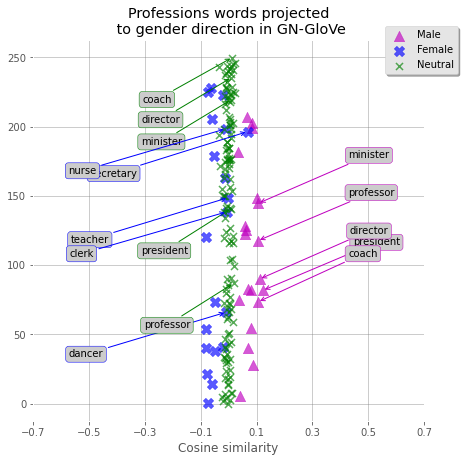

<Figure size 720x720 with 0 Axes>

In [328]:
fig = plt.figure(figsize=(7,7))
ax = fig.add_subplot(111)
ax.set_facecolor('white')
ax.grid(True, color='gray', alpha=0.5)
ax.scatter(male_vectors_cosine, y_male, marker="^", c='m', alpha=0.65, s=110)
ax.scatter(female_vectors_cosine, y_female, marker="X", c='b', alpha=0.65, s=110)
ax.scatter(neutral_vectors_cosine, y_neutral, marker="x",  c='g', alpha=0.65, s=50)
ax.set_xticks(np.arange(-0.7, 0.9, 0.2))
ax.set_xlabel("Cosine similarity")
ax.set_title("Professions words projected\n to gender direction in GN-GloVe")
ax = plt.gca()

# Annotations
n = 5
for i, m, f, n in zip(range(n), male_vectors['word'], female_vectors['word'], neutral_vectors['word']):
  # male annotations
  male_annotate = ax.annotate(m,
            (male_vectors_cosine[i], y_male[i]),
            xytext = (2 * offset, offset),
            xycoords ='data',
            textcoords ='offset points',
            bbox = male_bbox,
            arrowprops = male_arrowprops)

  # male annotations
  female_annotate = ax.annotate(f,
            (female_vectors_cosine[i], y_female[i]),
            xytext = (-3.5 * offset, -offset),
            xycoords ='data',
            textcoords ='offset points',
            bbox = female_bbox,
            arrowprops = female_arrowprops)

  # male annotations
  neutral_annotate = ax.annotate(m,
            (neutral_vectors_cosine[i], y_neutral[i]),
            xytext = (-2 * offset, -offset),
            xycoords ='data',
            textcoords ='offset points',
            bbox = neutral_bbox,
            arrowprops = neutral_arrowprops)

plt.figure(figsize=(10, 10))
# ax.get_yaxis().set_visible(False)

ax.legend(["Male", "Female", "Neutral"], bbox_to_anchor=(1.1, 1.05), fancybox=True, shadow=True)
plt.show()